In [75]:
import torch
import os
import soundfile
from scipy.signal import resample
import librosa
from nnAudio import Spectrogram
import matplotlib.pyplot as plt

os.environ['CUDA_VISIBLE_DEVICES'] = '3'
from evaluate import *
from mir_eval.multipitch import evaluate as evaluate_frames
from mir_eval.transcription import precision_recall_f1_overlap as evaluate_notes

if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

In [76]:
from scipy.stats import hmean

# Loading model

In [2]:
HOP_LENGTH = HOP_LENGTH*2

In [3]:
model = 'biTCN2_big2smallchannel'
model_file = os.path.join('./runs',model,'model-2000.pt')
dataset = 'MAPS'
dataset_group = None
save_path = os.path.join('results',model)
sequence_length = None
onset_threshold = 0.5
frame_threshold = 0.5
device = 'cuda:0'
model = torch.load(model_file, map_location=device)
summary(model)

melspectrogram = Spectrogram.MelSpectrogram(SAMPLE_RATE, WINDOW_LENGTH, N_MELS, HOP_LENGTH,
                                            fmin=MEL_FMIN, fmax=MEL_FMAX, trainable_mel=True, device=DEFAULT_DEVICE)

OnsetsAndFrames_biTCN(
  (onset_stack): Onset_Stack_bi(
    (layer1): ConvStack(
      (cnn): Sequential(
        (0): Conv2d(1, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), 480 params
        (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 96 params
        (2): ReLU(), 0 params
        (3): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), 20,784 params
        (4): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 96 params
        (5): ReLU(), 0 params
        (6): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False), 0 params
        (7): Dropout(p=0.25, inplace=False), 0 params
        (8): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), 41,568 params
        (9): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 192 params
        (10): ReLU(), 0 params
        (11): MaxPool2d(kernel_size=(1, 2), stride

STFT filter created, time used = 0.2491 seconds
Mel filter created, time used = 0.0062 seconds


# Loading audio file

In [4]:
audio_path = './test_audio/1759.wav'

In [5]:
audio, sr = librosa.load(audio_path, sr=16000)

In [6]:
audio = torch.tensor(audio).to(device)

# Feed-forward the audio

In [8]:
mel = melspectrogram(audio) # Getting spectrogram
mel = mel.transpose(-1,-2) # Swapping x and y axes of the piano roll
onset_pred, activation_pred, frame_pred = model(mel) # Getting prediction

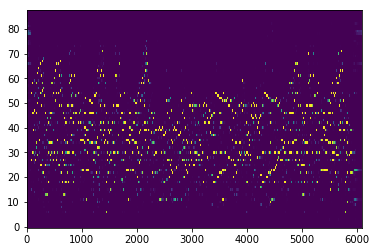

In [34]:
plt.imshow(frame_pred.detach().cpu()[0].T, origin='lower', aspect='auto') # Visualizing the output

# Evaluation

In [37]:
import pandas as pd
from evaluate import extract_notes_wo_velocity

## Getting labels

In [38]:
midi = pd.read_csv('./test_audio/1759.csv')

In [39]:
n_steps = len(audio-1)//HOP_LENGTH + 1
n_keys = 88

In [40]:
label = torch.zeros(n_steps, n_keys, dtype=torch.uint8)
for idx, data in midi.iterrows():
    onset = data['start_time']
    offset = data['end_time']
    note = data['note']
    
    left = int(round(onset / 44100 * SAMPLE_RATE / HOP_LENGTH)) # Convert time to time step
    onset_right = min(n_steps, left + HOPS_IN_ONSET) # Ensure the time step of onset would not exceed the last time step
    frame_right = int(round(offset / 44100 * SAMPLE_RATE / HOP_LENGTH))
    frame_right = min(n_steps, frame_right) # Ensure the time step of frame would not exceed the last time step
    offset_right = min(n_steps, frame_right + HOPS_IN_OFFSET)    

#     print(f'left = {left}')
#     print(f'right = {frame_right}')
    
    f = int(note) - MIN_MIDI
    label[left:onset_right, f] = 3
    label[onset_right:frame_right, f] = 2
#     label[frame_right:offset_right, f] = 1

In [ ]:
evaluate_frames()

In [79]:
def evaluate(onset_pred, frame_pred, label):
    # Converting pianoroll to pitch and interval format
    p_ref, i_ref = extract_notes_wo_velocity((label == 3).float(), (label > 1).float(), 0.5, 0.5)
    p_est, i_est = extract_notes_wo_velocity(onset_pred, frame_pred, 0.5, 0.5)    
    
    # Extracting frames from pitch and interval info
    t_est, f_est = notes_to_frames(p_est, i_est, frame_pred.shape)
    t_ref, f_ref = notes_to_frames(p_ref, i_ref, (label > 1).float().shape)
    
    
    
    scaling = HOP_LENGTH / SAMPLE_RATE # calculate the scale for the following conversions
    # Converting time steps to seconds and midi number to frequency
    i_ref = (i_ref * scaling).reshape(-1, 2)
    p_ref = np.array([midi_to_hz(MIN_MIDI + midi) for midi in p_ref])
    i_est = (i_est * scaling).reshape(-1, 2)
    p_est = np.array([midi_to_hz(MIN_MIDI + midi) for midi in p_est])

    t_ref = t_ref.astype(np.float64) * scaling
    f_ref = [np.array([midi_to_hz(MIN_MIDI + midi) for midi in freqs]) for freqs in f_ref]
    t_est = t_est.astype(np.float64) * scaling
    f_est = [np.array([midi_to_hz(MIN_MIDI + midi) for midi in freqs]) for freqs in f_est]
    
    p, r, f, o = evaluate_notes(i_ref, p_ref, i_est, p_est, offset_ratio=None)    
    frame_metrics = evaluate_frames(t_ref, f_ref, t_est, f_est)
    
    print(f'------Note-wise metric-----\n'
          f'precision={p:.4f}\trecall={r:.4f}\tF1 score={f:.4f}')
    print(f'------Frame-wise metric-----\n'
          f"precision={frame_metrics['Precision']:.4f}\trecall={frame_metrics['Recall']:.4f}\tF1 score={hmean([frame_metrics['Precision'],frame_metrics['Recall']]):.4f}")

In [80]:
evaluate(onset_pred[0], frame_pred[0], label)

------Note-wise metric-----
precision=0.7234	recall=0.6283	F1 score=0.6725
------Frame-wise metric-----
precision=0.6547	recall=0.4367	F1 score=0.5239


In [72]:
print()

precision=0.6447	recall=0.4643	F1 score=0.3697


In [60]:
frame_metrics

OrderedDict([('Precision', 0.644677284157586),
             ('Recall', 0.46426415549921524),
             ('Accuracy', 0.3696707522230233),
             ('Substitution Error', 0.15338645418326693),
             ('Miss Error', 0.3823493903175178),
             ('False Alarm Error', 0.10249909453096705),
             ('Total Error', 0.6382349390317518),
             ('Chroma Precision', 0.7066219614417435),
             ('Chroma Recall', 0.5088735965229989),
             ('Chroma Accuracy', 0.42011362503737665),
             ('Chroma Substitution Error', 0.10877701315948328),
             ('Chroma Miss Error', 0.3823493903175178),
             ('Chroma False Alarm Error', 0.10249909453096705),
             ('Chroma Total Error', 0.5936254980079682)])

# Exporting as midi

In [49]:
def save_midi(path, pitches, intervals, velocities):
    """
    Save extracted notes as a MIDI file
    Parameters
    ----------
    path: the path to save the MIDI file
    pitches: np.ndarray of bin_indices
    intervals: list of (onset_index, offset_index)
    velocities: list of velocity values
    """
    file = MidiFile()
    track = MidiTrack()
    file.tracks.append(track)
    ticks_per_second = file.ticks_per_beat * 2.0

    events = []
    for i in range(len(pitches)):
        events.append(dict(type='on', pitch=pitches[i], time=intervals[i][0], velocity=velocities[i]))
        events.append(dict(type='off', pitch=pitches[i], time=intervals[i][1], velocity=velocities[i]))
    events.sort(key=lambda row: row['time'])

    last_tick = 0
    for event in events:
        current_tick = int(event['time'] * ticks_per_second)
        velocity = int(event['velocity'] * 127)
        if velocity > 127:
            velocity = 127
        pitch = int(round(hz_to_midi(event['pitch'])))
        track.append(Message('note_' + event['type'], note=pitch, velocity=velocity, time=current_tick - last_tick))
        last_tick = current_tick

    file.save(path)

In [50]:
midi_path='./test_audio/1759.midi'

In [51]:
from mido import Message, MidiFile, MidiTrack
from mir_eval.util import hz_to_midi

In [52]:
save_midi(midi_path, p_est, i_est, [127]*len(p_est))